# QOSF Task 2

<font size="3.5"> 
This notebook has been written for the Quantum Open-Source Foundation Mentorship Program screening process.

The task is to implement a quantum circuit that returns |01> and |10> with equal probability. 

Requirements:
- The circuit should consist only of CNOTs, RXs and RYs.
- Start from all parameters in parametric gates being equal to 0 or randomly chosen.
- Find the right set of parameters using gradient descent (or more advanced optimization methods).
- Simulations must be done with sampling - i.e. a limited number of measurements per iteration and noise.

Compare the results for different numbers of measurements: 1, 10, 100, 1000.

Bonus question: How to make sure you produce state  |01⟩  +  |10⟩  and not any other combination of |01> + e(i*phi)|10⟩ (for example |01⟩  -  |10⟩)? 

<hr style="border-width:thin"> </hr>

Notebook pre-requisites: Install qiskit and pylatexenc (for circuit display in mpl) using pip install
</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_vector, plot_state_qsphere, plot_histogram

Desired two-qubit state: [0.        +0.j 0.70710678+0.j 0.70710678+0.j 0.        +0.j]


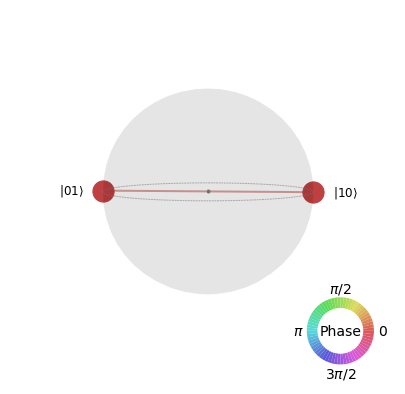

In [2]:
#Initialise the desired |01> + |10> state directly for visualisation. Normalisation factors
bell_state = [0, 1/np.sqrt(2), 1/np.sqrt(2), 0]
sv = Statevector(bell_state)
print("Desired two-qubit state:", sv.data)
plot_state_qsphere(sv)

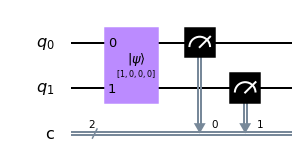

In [8]:
#Initialize a circuit with |00> initial state
def initializeCircuit():
    
    #Qiskit initializes qubits to the |0> state by default, but here we initialise it explicitly
    initial_state = [1., 0., 0., 0.]
    
    #Define a two-qubit quantum register and two-bit classical register
    q_reg = QuantumRegister(2, 'q')
    c_reg = ClassicalRegister(2, 'c')
    
    #Define circuit with registers and initialize to the |00> state
    circuit = QuantumCircuit(q_reg, c_reg)
    circuit.initialize(initial_state, [q_reg[0], q_reg[1]])
    
    return circuit, q_reg, c_reg
    
initial_circ, q_reg, c_reg = initializeCircuit()
initial_circ.measure(q_reg, c_reg)
initial_circ.draw('mpl')


Total count: {'00': 1000}


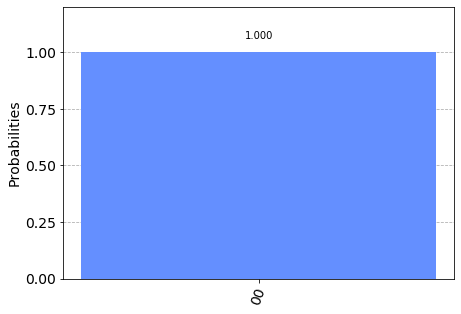

In [9]:
#Run simulation of circuit on noisy backend and output results

def runBackend(circuit, num_shots=1000, backend='qasm_simulator', hist=True):
    
    #Set up access to backend for noisy quantum circuit simulator
    backend = Aer.get_backend(backend)
    
    #Execute circuit on backend
    job = execute(circuit, backend, shots=num_shots)
    
    #Obtain the measurement results over many iterations and print counts
    result = job.result()
    counts = result.get_counts(circuit)
    print("\nTotal count:",counts)
    
    #Plotting results in a histogram
    if hist:
        return plot_histogram(counts)
        
runBackend(initial_circ)

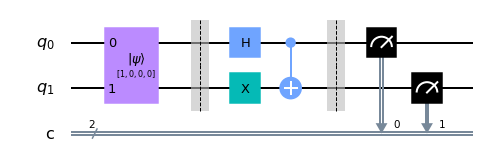

In [10]:
#Create Bell state using Hadamard and CNOT gates

#Initialize |00> state
circ, q_reg, c_reg = initializeCircuit()

#Apply gates to transform to desired Bell state
circ.barrier()
circ.x(q_reg[1])
circ.h(q_reg[0])
circ.cx(q_reg[0],q_reg[1])

#Measure qubits
circ.barrier()
circ.measure(q_reg, c_reg)

#Display circuit
circ.draw('mpl')


Total count: {'01': 50258, '10': 49742}


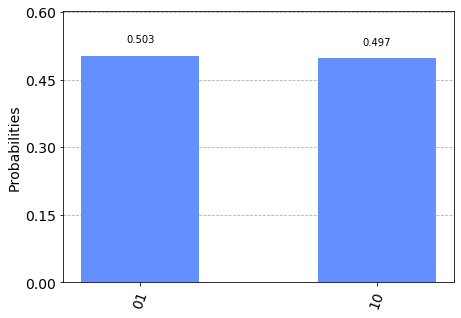

In [11]:
#Run circuit on backend and output results
num_shots = 100000
runBackend(circ, num_shots)

Circuit implemented that returns the desired state. But requirement says that Hadamard gate cannot be used. Need to decompose Hadamard into RX, RY and CNOT gates only.


Total count: {'00': 484, '01': 516}


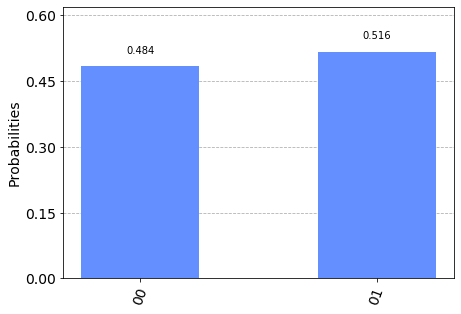

In [30]:
circ, q_reg, c_reg = initializeCircuit()
circ.h(q_reg[0])
circ.measure(q_reg, c_reg)
runBackend(circ)


Total count: {'00': 511, '01': 489}


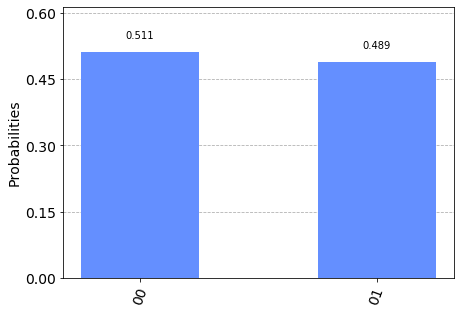

In [32]:
deg_90 = np.pi/2
deg_180 = np.pi

#H = XY^(1/2) (is this right? need to track global phase)
circ, q_reg, c_reg = initializeCircuit()
circ.ry(deg_90, q_reg[0])
circ.rx(deg_180, q_reg[0])
circ.measure(q_reg, c_reg)
runBackend(circ)


Total count: {'00': 501, '01': 499}


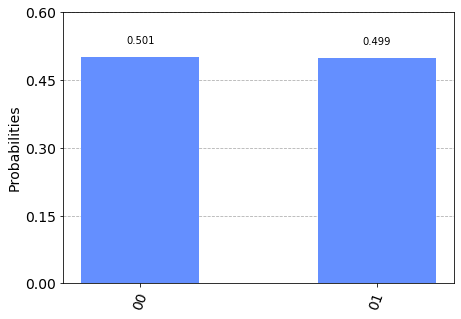

In [39]:
#H = Y^(-1/2)X
circ, q_reg, c_reg = initializeCircuit()
circ.rx(deg_180, q_reg[0])
circ.ry(-deg_90, q_reg[0])
circ.measure(q_reg, c_reg)
runBackend(circ)

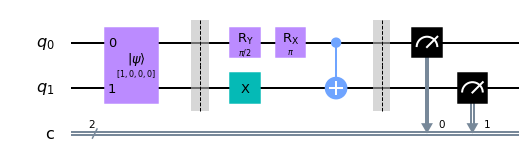

In [34]:
#Create Bell state using Hadamard and CNOT gates

#Initialize |00> state
circ, q_reg, c_reg = initializeCircuit()

#Apply gates to transform to desired Bell state
circ.barrier()
circ.x(q_reg[1])

#Decomposed H
circ.ry(deg_90, q_reg[0])
circ.rx(deg_180, q_reg[0])

circ.cx(q_reg[0],q_reg[1])

#Measure qubits
circ.barrier()
circ.measure(q_reg, c_reg)

#Display circuit
circ.draw('mpl')


Total count: {'01': 49961, '10': 50039}


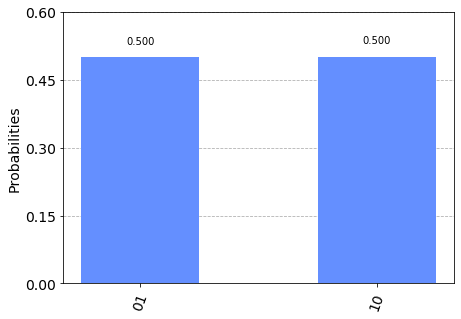

In [35]:
#Run circuit on backend and output results
num_shots = 100000
runBackend(circ, num_shots)

Successful decomposition of Hadamard gate. Bell state generator works with known gate parameters from theory. Need to implement gradient descent (or other optimization methods) to determine the parameters. 